# İkinci El Araba Fiyatı Tahmini

In [75]:
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [76]:
%cd /content/sample_data

cars=pd.read_csv('train.csv')

/content/sample_data


In [77]:
marka=[]
for i in range(cars.shape[0]):
  marka.append(cars['Name'][i].split()[0])

In [78]:
marka_one_hot     = pd.get_dummies(marka,dtype=float)
location_one_hot  = pd.get_dummies(cars['Location'],dtype=float)
age               = 2024-cars['Year']
fuel_one_hot      = pd.get_dummies(cars['Fuel_Type'],dtype=float)
trans_one_hot     = pd.get_dummies(cars['Transmission'],dtype=float)
owner_one_hot     = pd.get_dummies(cars['Owner_Type'],dtype=float)

In [79]:
mil=[]
for i in range(cars.shape[0]):
  try:
    mil.append(float(cars['Mileage'][i].split()[0]))
  except:
    mil.append(np.mean(mil))

In [80]:
engine=[]
for i in range(cars.shape[0]):
  try:
    engine.append(float(cars['Engine'][i].split()[0]))
  except:
    engine.append(np.mean(engine))

In [81]:
power=[]
for i in range(cars.shape[0]):
  try:
    power.append(float(cars['Power'][i].split()[0]))
  except:
    power.append(np.mean(power))

In [82]:
seats=[]
for i in range(cars.shape[0]) :
  if np.isnan(cars['Seats'][i]) or cars['Seats'][i]==0:
    seats.append(np.mean(seats))
  else:
    seats.append(cars['Seats'][i])

In [83]:
veri=pd.concat([marka_one_hot,
                location_one_hot,
                age,
                cars['Kilometers_Driven'],
                fuel_one_hot,
                trans_one_hot,
                owner_one_hot,
                pd.Series(mil),
                pd.Series(engine),
                pd.Series(power),
                pd.Series(seats)],
               axis=1)

In [84]:
# İlk 4000 satırı eğitim seti olarak alalım, kalanları test seti yapalım
X_train = veri[:4000]
X_test = veri[4000:]
y_train = cars['Price'][:4000]
y_test = cars['Price'][4000:]

# Verileri torch tensorlerine çevir
veri_torch_train = torch.from_numpy(np.array(X_train)).float()
veri_torch_test = torch.from_numpy(np.array(X_test)).float()
hedef_torch_train = torch.from_numpy(np.array(y_train)).float()
hedef_torch_test = torch.from_numpy(np.array(y_test)).float()

In [85]:
def model(X,W,b):
  return X@W+b
  #return torch.matmul(X,W)+b

In [86]:
def kayip_fonk(tahmin,gercek):
  farklar_karesi=(tahmin-gercek)**2
  return farklar_karesi.mean()

In [87]:
#Baslangic W ve b degerleri oluşturalim
W=torch.ones(veri_torch_train.shape[1],requires_grad=True)
b=torch.tensor([0.0],requires_grad=True)

In [88]:
optim_araci=optim.Adam([W,b],lr=0.01)

In [89]:
kayip_list=[]
for epoch in range(10000):
  tahmin=model(veri_torch_train,W,b)
  kayip=kayip_fonk(tahmin,hedef_torch_train)

  kayip.backward()
  optim_araci.step()
  optim_araci.zero_grad()

  #print(f'Epoch: {epoch} icin kayip miktari: {kayip:.3f}')
  kayip_list.append(kayip.item())

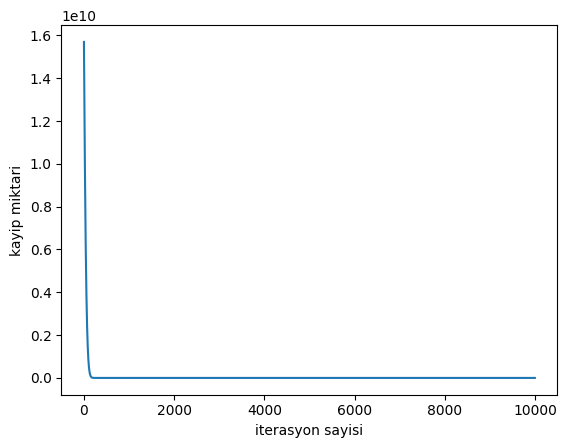

In [90]:
plt.plot(torch.arange(10000),kayip_list)
plt.xlabel('iterasyon sayisi')
plt.ylabel('kayip miktari')
plt.show()

In [91]:
# test verimizde tahmin yapalım
with torch.no_grad():   # grad hesabını test aşamasında kullanmamak daha faydalı
    tahmin_test = model(veri_torch_test, W, b)

# Mean Squared Error hesaplayalım
mse = kayip_fonk(tahmin_test, hedef_torch_test)
print(f'Test Seti İçin MSE: {mse:.3f}')

# Tahmin edilen sonuçları numpy dizisine dönüştürelim
tahmin_test_np = tahmin_test.numpy()

# Gerçek test değerleriyle birlikte karşılaştıralım
gercek_test_np = hedef_torch_test.numpy()

# İlk 10 tahmin ile gerçek fiyatları karşılaştıralım
for i in range(10):
    print(f"Gerçek Fiyat: {gercek_test_np[i]:.2f}, Tahmin Edilen Fiyat: {tahmin_test_np[i]:.2f}")

Test Seti İçin MSE: 43.749
Gerçek Fiyat: 1.80, Tahmin Edilen Fiyat: 2.44
Gerçek Fiyat: 6.25, Tahmin Edilen Fiyat: 17.21
Gerçek Fiyat: 5.45, Tahmin Edilen Fiyat: 5.86
Gerçek Fiyat: 52.50, Tahmin Edilen Fiyat: 25.73
Gerçek Fiyat: 5.60, Tahmin Edilen Fiyat: 10.29
Gerçek Fiyat: 6.45, Tahmin Edilen Fiyat: 8.14
Gerçek Fiyat: 3.70, Tahmin Edilen Fiyat: 3.69
Gerçek Fiyat: 3.49, Tahmin Edilen Fiyat: 4.14
Gerçek Fiyat: 3.55, Tahmin Edilen Fiyat: 5.03
Gerçek Fiyat: 9.00, Tahmin Edilen Fiyat: 17.46


In [92]:
# Yeni bir araba verisi
yeni_araba = {
    'Name': 'Toyota Corolla',
    'Location': 'Pune',
    'Year': 2020,
    'Kilometers_Driven': 30000,
    'Fuel_Type': 'Petrol',
    'Transmission': 'Manual',
    'Owner_Type': 'First',
    'Mileage': '15.0 kmpl',
    'Engine': '1500 CC',
    'Power': '100 bhp',
    'Seats': 5,
    'New_Price': '7.03 Lakh',
    'Price': 6.5
}

In [93]:
marka_one_hot_yeni        = pd.get_dummies([yeni_araba['Name'].split()[0]], dtype=float).reindex(columns=marka_one_hot.columns, fill_value=0.0)
location_one_hot_yeni     = pd.DataFrame(0, index=[0], columns=location_one_hot.columns)
age_yeni                  = pd.Series([2024 - yeni_araba['Year']])
fuel_one_hot_yeni         = pd.get_dummies([yeni_araba['Fuel_Type']], dtype=float).reindex(columns=fuel_one_hot.columns, fill_value=0.0)
trans_one_hot_yeni        = pd.get_dummies([yeni_araba['Transmission']], dtype=float).reindex(columns=trans_one_hot.columns, fill_value=0.0)
owner_one_hot_yeni        = pd.get_dummies([yeni_araba['Owner_Type']], dtype=float).reindex(columns=owner_one_hot.columns, fill_value=0.0)

kilometers_yeni           = pd.Series([yeni_araba['Kilometers_Driven']])
mileage_yeni              = pd.Series([float(yeni_araba['Mileage'].split()[0])])
engine_yeni               = pd.Series([float(yeni_araba['Engine'].split()[0])])
power_yeni                = pd.Series([float(yeni_araba['Power'].split()[0])])
seats_yeni                = pd.Series([float(yeni_araba['Seats'])])

# Tüm yeni araba verilerini bir araya getiriyoruz
yeni_araba_veri = pd.concat([
    marka_one_hot_yeni.reset_index(drop=True),
    location_one_hot_yeni.reset_index(drop=True),
    age_yeni.reset_index(drop=True, name='Age'),
    kilometers_yeni.reset_index(drop=True, name='Kilometers_Driven'),
    fuel_one_hot_yeni.reset_index(drop=True),
    trans_one_hot_yeni.reset_index(drop=True),
    owner_one_hot_yeni.reset_index(drop=True),
    mileage_yeni.reset_index(drop=True, name='Mileage'),
    engine_yeni.reset_index(drop=True, name='Engine'),
    power_yeni.reset_index(drop=True, name='Power'),
    seats_yeni.reset_index(drop=True, name='Seats')
], axis=1)

yeni_araba_torch = torch.from_numpy(np.array(yeni_araba_veri)).float()

In [94]:
with torch.no_grad():
    tahmin_yeni_araba = model(yeni_araba_torch, W, b)

print(f"Yeni araba için tahmin edilen fiyat: {tahmin_yeni_araba.item():.2f}")

Yeni araba için tahmin edilen fiyat: 9.16


In [104]:
# Benzer arabalara filtre uygula
benzer_arabalar = cars[
    (cars['Name'].str.contains('Toyota')) &
    # (cars['Year'] == 2020) &
    (cars['Kilometers_Driven'] <= 35000) &  # 30,000 ile 35,000 km arasında
    (cars['Fuel_Type'] == 'Petrol') &
    (cars['Transmission'] == 'Manual') &
    (cars['Owner_Type'] == 'First')
]

# Gerçek fiyatı görüntüle
gercek_fiyatlar = benzer_arabalar['Price'].to_string(index=False)
print(gercek_fiyatlar)

 4.95
 5.00
 2.44
 7.27
 7.95
 6.58
 3.55
14.60
11.00
 6.37
 4.50
